In [1]:
# If on cluster, cwd is '/rds/general/user/nz423', not the project directory, breaking imports
import os
import sys
from pathlib import Path

project_dir = Path(os.getcwd()) / "exploring-hydra-boosting"
if "rds" not in project_dir.parts:
    project_dir = project_dir.parent
    datasets_dir = project_dir.parent.parent / "Data"
else:
    datasets_dir = project_dir / "DATASETS"
    if str(project_dir) not in sys.path:
        sys.path.append(str(project_dir))
    
class Config:
    project_dir = project_dir
    TSER_dir = datasets_dir / "TSER"
    BigTSC_dir = datasets_dir / "BigTSC"
    UTSC_dir = datasets_dir / "UTSC"

print(Config.project_dir)
print(Config.TSER_dir)
print(Config.BigTSC_dir)
print(Config.UTSC_dir)

c:\Users\nz423\Code\exploring-hydra-boosting
c:\Users\nz423\Data\TSER
c:\Users\nz423\Data\BigTSC
c:\Users\nz423\Data\UTSC


In [2]:
from typing import Tuple, List, Union, Any, Optional, Dict, Literal, Callable
import time
import os
import sys
import pathlib
from pathlib import Path


import numpy as np
import aeon
import torch
from torch import Tensor
import torch.nn as nn
import torch.functional as F
import pandas as pd
from aeon.datasets.tser_datasets import tser_soton; tser_soton = sorted(list(tser_soton))
from aeon.datasets import load_regression
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import RidgeCV
from tqdm import tqdm
np.set_printoptions(precision=3, threshold=5) # Print options

# Regressor testing

In [3]:
import numpy as np
import pandas as pd
from aeon.benchmarking.results_loaders import get_estimator_results
from aeon.datasets import load_regression
from aeon.regression import DummyRegressor
from aeon.visualisation import plot_critical_difference
from sklearn.metrics import mean_squared_error
from tsml.datasets import load_minimal_gas_prices
from aeon.datasets.tser_datasets import tser_soton; tser_soton = sorted(list(tser_soton))

from tsml_eval.evaluation.storage import load_regressor_results
from tsml_eval.experiments import (
    experiments,
    get_regressor_by_name,
    run_regression_experiment,
)

# print("TSER", "len", len(tser_soton), tser_soton)

c:\Users\nz423\Code\exploring-hydra-boosting\.venv\Lib\site-packages\aeon\base\__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


In [4]:
# # set_regressor can be used to find various regressors by string, but
# # any aeon, tsml or sklearn regressor can be used in the experiments function
# regressor = get_regressor_by_name("DummyRegressor")

# # record memory usage every 0.1 seconds, just here for notebook speed
# # does not need to be changed for usage
# experiments.MEMRECORD_INTERVAL = 0.1

# run_regression_experiment(
#     X_train,
#     y_train,
#     X_test,
#     y_test,
#     regressor,
#     Config.project_dir / "results",
#     dataset_name=dataset_name,
#     resample_id=0,
# )

# rr = load_regressor_results(
#     Config.project_dir / "results" / "DummyRegressor" / "Predictions" / dataset_name / "testResample0.csv"
# )
# print(rr.predictions)
# print(rr.mean_squared_error, "mse")
# print(rr.root_mean_squared_error, "rmse")
# print(rr.mean_absolute_percentage_error, "mape")
# print(rr.r2_score, "r2")

In [5]:
# # set_regressor can be used to find various regressors by string, but
# # any aeon, tsml or sklearn regressor can be used in the experiments function
# regressor = get_regressor_by_name("multirockethydra")

# # record memory usage every 0.1 seconds, just here for notebook speed
# # does not need to be changed for usage
# experiments.MEMRECORD_INTERVAL = 0.1

# run_regression_experiment(
#     X_train,
#     y_train,
#     X_test,
#     y_test,
#     regressor,
#     Config.project_dir / "results",
#     dataset_name=dataset_name,
#     resample_id=0,
# )

# rr = load_regressor_results(
#     Config.project_dir / "results" / "MultiRocketHydraRegressor" / "Predictions" / dataset_name / "testResample0.csv"
# )
# print(rr.predictions)
# print(rr.mean_squared_error, "mse")
# print(rr.root_mean_squared_error, "rmse")
# print(rr.mean_absolute_percentage_error, "mape")
# print(rr.r2_score, "r2")

# benchmark against other

In [29]:
from run_regression_experiments import TSER_datasets
# datasets = [
#     "CardanoSentiment",
#     "Covid3Month",
#     "FloodModeling1",
#     "FloodModeling2",
#     "NaturalGasPricesSentiment",
#     #"MethaneMonitoringHomeActivity",
#     "HouseholdPowerConsumption1",
#     #"AustraliaRainfall"
# ]

estimators = ["InceptionT", "FreshPRINCE", "DrCIF", "Rocket", "RandF", "RotF", "XGBoost", "Ridge"] #"MultiRocket"
benchmarks = get_estimator_results(
    datasets=TSER_datasets, estimators=estimators, task="regression", measure="rmse", 
    path = Config.project_dir / "data" / "bench_regression_TSER",
    default_only = True # default train/test (True) or 30 resamples (False) #TODO only suppporting default split atm
)


def add_regressor_to_benchmarks(
    model_name: str,
    datasets: List[str],
    results_dir: Path,
    benchmarks: Dict,
    ):
    results = {}
    for dataset_name in datasets:
        rr = load_regressor_results(
            results_dir / model_name / "Predictions" / dataset_name / f"testResample{0}.csv"
        )
        results[dataset_name] = rr.root_mean_squared_error
    benchmarks[model_name] = results
    return results


# add_regressor_to_benchmarks(
#     "HydraBoostGridSearchHoldout",
#     TSER_datasets,
#     Config.project_dir / "results",
#     benchmarks
#     )

In [30]:
table = pd.DataFrame(benchmarks)
table

,InceptionT,FreshPRINCE,DrCIF,Rocket,RandF,RotF,XGBoost,Ridge
BIDMC32HR,7.222708,10.616631,8.006972,6.813961,14.996338,4.947497,13.864843,14.868206
BIDMC32SpO2,5.784348,5.102724,4.855296,4.652436,4.549775,1.659771,4.436033,4.963935
PPGDalia,11.075060,15.241872,15.085781,14.096621,17.434028,14.764772,15.321998,20.754549
BIDMC32RR,3.221975,4.039938,4.301645,4.100524,4.345821,1.720790,4.314306,3.340824
NewsTitleSentiment,0.139854,0.142208,0.142239,0.143013,0.142700,0.145367,0.139338,0.139213
...,...,...,...,...,...,...,...,...
BitcoinSentiment,0.242200,0.226563,0.219815,0.295793,0.231098,0.195272,0.228481,0.260587
BinanceCoinSentiment,0.381258,0.339670,0.338732,0.387779,0.346741,0.347920,0.354200,0.397304
DailyOilGasPrices,1.542210,1.172234,1.046399,1.922385,1.208112,1.511486,1.390036,1.713667
CardanoSentiment,0.379025,0.289479,0.313388,0.298396,0.300677,0.322384,0.355953,0.389053


C:\Users\nz423\AppData\Local\Temp\ipykernel_8364\418295115.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


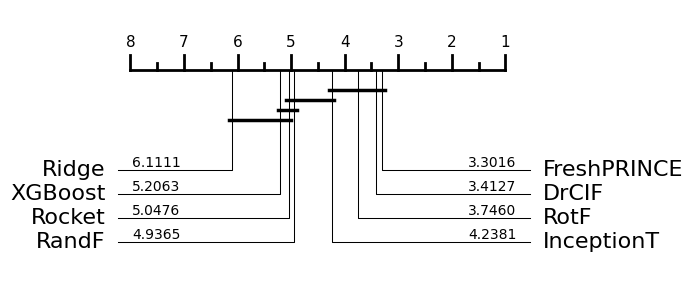

In [32]:
plt, _ = plot_critical_difference(
    np.array(table), list(table.columns), lower_better=True
)
plt.show()

# Classifier

In [ ]:
# TODO whats the proper way to load the TSC results? same library?

# Distribution of parameters

In [ ]:
def plot_distribution(
    parameters=["l2_ghat", "l2_reg", "n_layers"],
    model_name="HydraBoostGridSearchHoldout",
    results_dir: Path = Config.project_dir / "results",
):
    #step 1: loop over all csv files in results_dir / "Predictions"
    
    #step 2: in each csv file, the second line will be the parameter dict, for example {'seed': 0, 'boost_lr': 0.5, 'hydra_batch_size': 10000, 'init_n_groups': 64, 'init_n_kernels': 8, 'l2_ghat': 0.01, 'l2_reg': 0.01, 'max_num_channels': 3, 'n_groups': 64, 'n_kernels': 8, 'n_layers': 1}
    
    #step 3: retrieve all values from the dict with keys in 'parameters' arg.
    
    #step 4: plot histograms, side by side one with ordinary x scale, one with log x scale. take log 1+x too.
    # steal this from previous repo.

# TODO



Features:
* For now only do wide not deep representation boosting
* percentage of dataset to be used at each boosting iteration
* What solver to use for least squares? do i need batching here for the big datasets?
* How to initialize Phi_0? Should i use different n_features for the initial guess? Use all data for initial? TSFresh or hydra features? Or do i do some sort of flattened PCA?


Would be interesting to see difference between boosting in label space vs representation boosting